In [1]:
# -------------------------------
# 1) Mount Google Drive
# -------------------------------
from google.colab import drive
drive.mount('/content/drive')

# Path in your Drive where you want to store the dataset
import os
drive_path = "/content/drive/MyDrive/EKG MI Detection"
os.makedirs(drive_path, exist_ok=True)
print("All files will be stored in:", drive_path)

# -------------------------------
# 2) Install kagglehub
# -------------------------------
!pip install kagglehub

# -------------------------------
# 3) Download the PTB Diagnostic ECG dataset
# -------------------------------
import kagglehub

temp_path = kagglehub.dataset_download("shayanfazeli/heartbeat")  # If you later switch to official PTB Kaggle dataset, replace the ID
print("Dataset downloaded to temporary folder:", temp_path)

# -------------------------------
# 4) Copy dataset to Google Drive
# -------------------------------
!cp -r "{temp_path}"/* "{drive_path}/"
print("Dataset copied to Google Drive at:", drive_path)

# -------------------------------
# 5) Load the PTB dataset
# -------------------------------
import pandas as pd

# The PTB CSVs are in a folder inside drive_path called 'PTB_Diagnostic'
ptb_path = os.path.join(drive_path, "PTB_Diagnostic")

MessageError: Error: credential propagation was unsuccessful

In [5]:
# The PTB CSVs are in a folder inside drive_path called 'PTB_Diagnostic'
ptb_path = os.path.join(drive_path, "PTB_Diagnostic")

# Load abnormal ECGs (MI included in abnormal)
abnormal_csv = os.path.join(ptb_path, "ptbdb_abnormal.csv")

# Load healthy ECGs
normal_csv = os.path.join(ptb_path, "ptbdb_normal.csv")

KeyError: 'diagnosis'

Now lets create a new Combined dataset with normal and abnormal EKG readings.

In [12]:
# Number of samples to take from each
n_samples = 300
n_features = 188  # 0-187 are ECG points; 188th column already has labels

# Read the CSVs
normal_df = pd.read_csv(normal_csv, header=None)
abnormal_df = pd.read_csv(abnormal_csv, header=None)

# Take a batch of n_samples from each
normal_batch = normal_df.sample(n=n_samples, random_state=42).copy()
abnormal_batch = abnormal_df.sample(n=n_samples, random_state=42).copy()

# Combine and shuffle
combined_df = pd.concat([normal_batch, abnormal_batch], ignore_index=True)
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

print("Combined dataset shape:", combined_df.shape)  # Should be (600, 188)
print(combined_df.head())

# Save CSV
combined_csv_path = "/content/drive/MyDrive/EKG MI Detection/PTB_Diagnostic/ptb_combined_batch.csv"
combined_df.to_csv(combined_csv_path, index=False, header=False)
print("Combined batch saved to:", combined_csv_path)

Combined dataset shape: (600, 188)
        0         1         2         3         4         5         6    \
0  1.000000  0.345466  0.136336  0.327576  0.392350  0.299815  0.244294   
1  0.983014  0.853699  0.452055  0.127123  0.026301  0.223562  0.249315   
2  0.920000  0.964722  0.477500  0.170000  0.135556  0.108889  0.083889   
3  0.977616  0.393956  0.073867  0.000000  0.111919  0.196978  0.210968   
4  1.000000  0.512361  0.145419  0.044595  0.047504  0.117790  0.165778   

        7         8         9    ...  178  179  180  181  182  183  184  185  \
0  0.306601  0.267736  0.301049  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.269041  0.278904  0.255890  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.068611  0.070000  0.069444  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.216564  0.222160  0.222720  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.198740  0.204072  0.211343  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   186  187  
0  0.0  0.0  
1  0.

Now that we have created the combined dataset, lets plot one normal and one abnormal EKG:

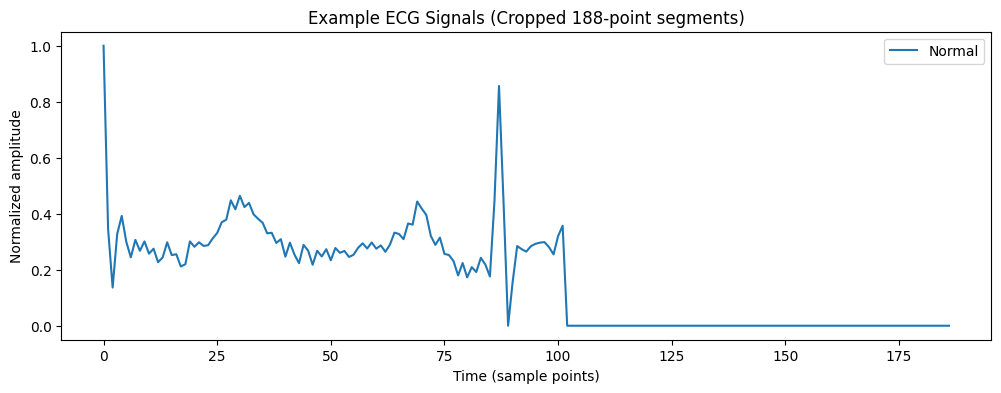

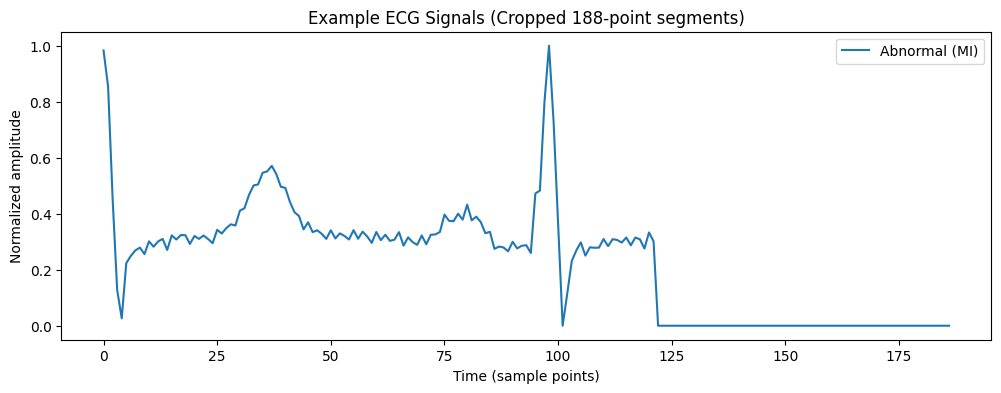

In [16]:
import matplotlib.pyplot as plt

# Picking one normal and one abnormal sample
normal_sample = combined_df[combined_df[187] == 0].iloc[0, :187].values
abnormal_sample = combined_df[combined_df[187] == 1].iloc[0, :187].values

# Plot
plt.figure(figsize=(12, 4))
plt.plot(normal_sample, label='Normal')
plt.title("Example ECG Signals (Cropped 188-point segments)")
plt.xlabel("Time (sample points)")
plt.ylabel("Normalized amplitude")
plt.legend()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(abnormal_sample, label='Abnormal (MI)')
plt.title("Example ECG Signals (Cropped 188-point segments)")
plt.xlabel("Time (sample points)")
plt.ylabel("Normalized amplitude")
plt.legend()
plt.show()

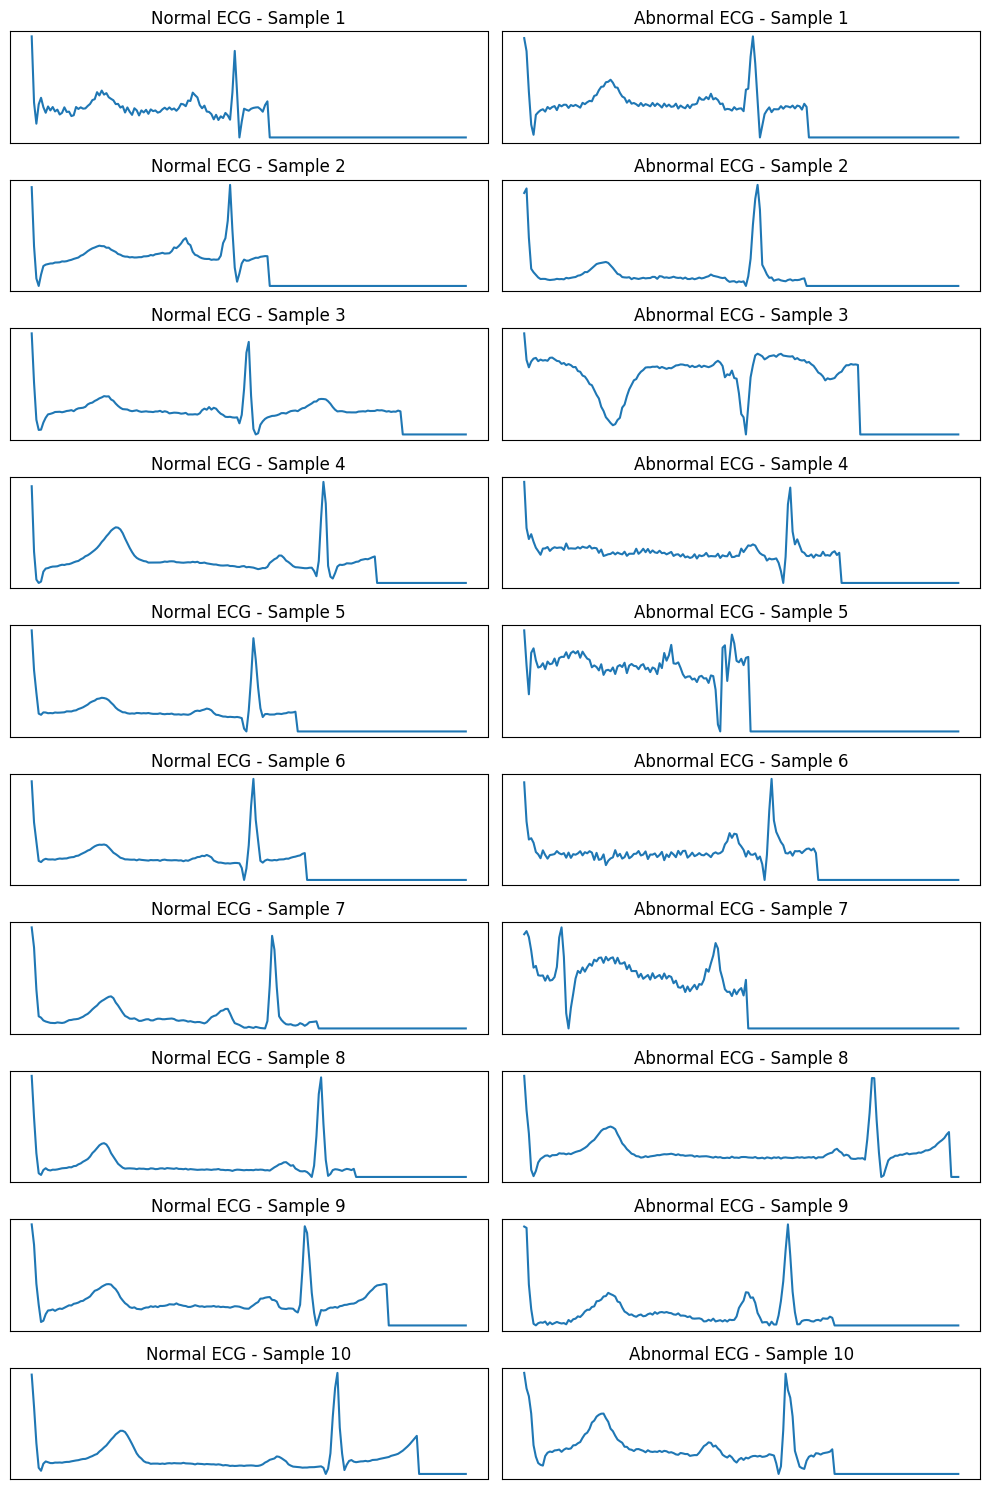

In [20]:
import matplotlib.pyplot as plt

# Select 10 normal and 10 abnormal samples
normal_samples = combined_df[combined_df[187] == 0].iloc[:10, :187].values
abnormal_samples = combined_df[combined_df[187] == 1].iloc[:10, :187].values

# Create figure with 10 rows, 2 columns
fig, axes = plt.subplots(10, 2, figsize=(10, 15))
axes = axes.flatten()

for i in range(10):
    # Left column: normal
    axes[2*i].plot(normal_samples[i])
    axes[2*i].set_title(f"Normal ECG - Sample {i+1}")
    axes[2*i].set_xticks([])
    axes[2*i].set_yticks([])

    # Right column: abnormal
    axes[2*i + 1].plot(abnormal_samples[i])
    axes[2*i + 1].set_title(f"Abnormal ECG - Sample {i+1}")
    axes[2*i + 1].set_xticks([])
    axes[2*i + 1].set_yticks([])

plt.tight_layout()
plt.show()

In [47]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Features and labels
X = combined_df.iloc[:, :187].values  # first 187 columns are ECG signal
y = combined_df.iloc[:, 187].values   # last column is label (0=normal, 1=abnormal)

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Reshape for CNN: (samples, timesteps, channels)
X_train = X_train[..., np.newaxis]  # shape = (num_samples, 187, 1)
X_test = X_test[..., np.newaxis]

In [49]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(187,1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.55),
    Dense(1, activation='sigmoid')  # binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)              │ (None, 185, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 185, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 92, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 90, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 90, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 45, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 2880)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │       184,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 191,169 (746.75 KB)

 Trainable params: 190,977 (746.00 KB)

 Non-trainable params: 192 (768.00 B)

In [50]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=70,
    batch_size=32
)

Epoch 1/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.5888 - loss: 0.9613 - val_accuracy: 0.7083 - val_loss: 0.5699
Epoch 2/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.7771 - loss: 0.5168 - val_accuracy: 0.8021 - val_loss: 0.5226
Epoch 3/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8447 - loss: 0.3807 - val_accuracy: 0.7396 - val_loss: 0.5114
Epoch 4/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8655 - loss: 0.3503 - val_accuracy: 0.7188 - val_loss: 0.4958
Epoch 5/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9247 - loss: 0.2100 - val_accuracy: 0.7188 - val_loss: 0.4891
Epoch 6/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9169 - loss: 0.2340 - val_accuracy: 0.7083 - val_loss: 0.5007
Epoch 7/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9456 - loss: 0.1856 - val_accuracy: 0.7188 - val_loss: 0.5192
Epoch 8/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9586 - loss: 0.1227 - val_accuracy: 0.7188 - v

In [51]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc*100:.2f}%")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8248 - loss: 0.8633 
Test Accuracy: 86.67%


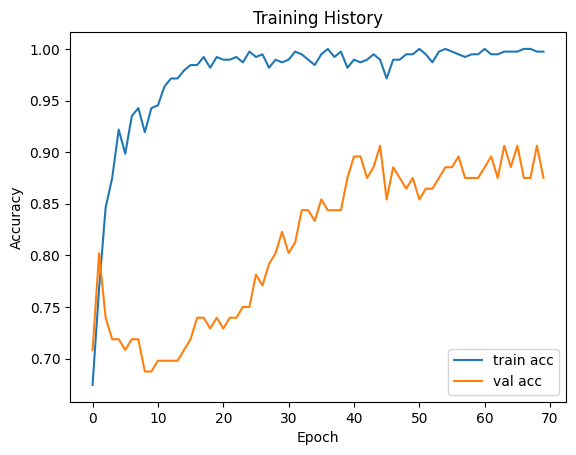

In [52]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title("Training History")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


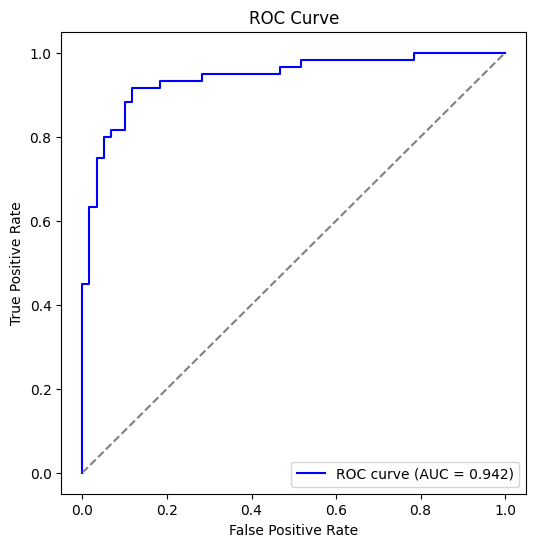

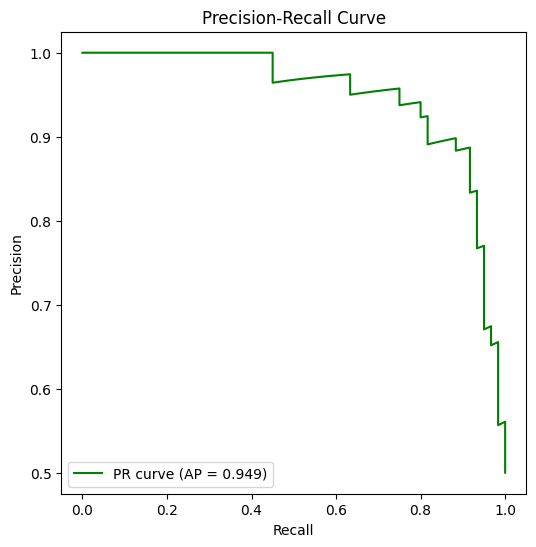

In [53]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Predict probabilities for test set
y_prob = model.predict(X_test).ravel()  # flatten to 1D array

# ---------- ROC AUC ----------
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='grey', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# ---------- Precision-Recall ----------
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_prob)
avg_precision = average_precision_score(y_test, y_prob)

plt.figure(figsize=(6,6))
plt.plot(recall, precision, color='green', label=f'PR curve (AP = {avg_precision:.3f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.show()